In [1]:
%matplotlib inline

In [2]:
import numpy as np
from fuel.datasets.hdf5 import H5PYDataset
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

BATH_SIZE = 100
IMG_SIZE = 256

# Img resizing stuff
LR_HR_RATIO = 4
BIG_SIZE = int(IMG_SIZE * 76 / 64)
SMALL_SIZE = int(BIG_SIZE / LR_HR_RATIO)

DATA_TEMPLATE = '/data/fashion/extract_sample_3_%i_%i.h5'
LANGUAGE_MODEL_VOCABULARY = '/data/models/glove.6B.vocab'

FASTTEXT_DATA = '/data/fashion/txt/fashion.dedup.txt'
FASTTEXT_DATA_TRAIN = '/data/fashion/txt/fashion-train.txt'
FASTTEXT_DATA_CLEAN = '/data/fashion/txt/fashion-clean.txt'

In [28]:
import json
categories = json.load(open('/data/fashion/categories.json', 'rt'))
id2category = { v: str(k) for k, v in categories.iteritems() }

In [5]:
data_set = H5PYDataset(DATA_TEMPLATE % (IMG_SIZE, IMG_SIZE), which_sets=('all',))

In [6]:
print("There are %i examples" % data_set.num_examples)

There are 186759 examples


In [29]:
import string
from collections import Counter

BLACK_LIST = string.punctuation.replace('%', '') + '\n'

def normalize(text_array, black_list = BLACK_LIST, vocab=None, lowercase =  True, tokenize = False):
    text = text_array[0][0]
    if black_list:
        text = text.translate(None, BLACK_LIST)
    if lowercase:
        text = text.lower()
    if vocab:
        text = ' '.join([word for word in text.split() if word in vocab])
    if tokenize:
        return text.split()
    return text

def encode_fast_text(label, text):
    clean_label = label.lower().replace(" ", "-")
    clean_text = ' '.join(text[0][0].split())
    return "__label__%s %s\n" % (clean_label, clean_text)

In [30]:
data_set.num_examples

186759

In [31]:
def dump_to_fastext_corpora(data_set, output, id2category,
                            batch_size = BATH_SIZE, 
                            limit=None):
    '''
    Dumps the dataset to be consumed by fastT ext.
    '''
    N = data_set.num_examples
    num_batch = N / batch_size
    
    handle = data_set.open()
    with open(output, 'wr') as f:
        processed = 0
        for i in itertools.islice(xrange(num_batch), limit):
            # fetch batch of data
            text_batch, img_batch, metadata_batch  = data_set.get_data(
                handle, slice(i*batch_size, min((i+1)*batch_size, N - processed)))
            
            # process batch
            lines = [encode_fast_text(id2category[id_], text) for 
                     text, id_ in zip(text_batch, metadata_batch[:,0])]

            # dumplines
            f.writelines(lines)
            
            # track progress 
            processed += text_batch.shape[0]   
            if i % 100 == 0:
                percent = int(((100.0 * i )/ num_batch))
                print("Processing %i batch out of %i [%i processed]" % (i +1, num_batch +1, processed))

In [ ]:
# dump_to_fastext_corpora(data_set, FASTTEXT_CORPORA, id2category)

In [ ]:
import itertools
import math

c = Counter()
handle = data_set.open()
num_batch = data_set.num_examples / BATH_SIZE
for i in xrange(num_batch):
    if i % 100 == 0:
        percent = int(((100.0 * i )/ num_batch))
        print("Processing %i batch out of %i [%i percent]" % (i, num_batch, percent))
        print("Number of tokens in the dictionary: %i" % len(c))
    text_batch, img_batch, metadata_batch  = \
    data_set.get_data(
        handle, 
        slice(i*BATH_SIZE, min((i+1)*BATH_SIZE, data_set.num_examples))
    )
    
    tokens = itertools.chain(*[normalize(text, tokenize=True) for text in text_batch])
    c.update(tokens)

In [32]:
c.most_common(10)

[('in', 66373),
 ('at', 50660),
 ('tonal', 32216),
 ('leather', 26164),
 ('and', 20352),
 ('black', 20024),
 ('sole', 15533),
 ('collar', 14415),
 ('closure', 12735),
 ('sleeve', 11325)]

# Are we missing something?

In [35]:
with open(LANGUAGE_MODEL_VOCABULARY, 'rt') as f:
    vocab = set(f.read().split('\n'))

In [36]:
missing_words = Counter({ word: c[word] for word in c if word.lower() not in vocab})
print("There are %i missing words out of %i" % (len(missing_words), len(c)))
print("Most common mising words")
missing_words.most_common(10)

There are 1326 missing words out of 3592
Most common mising words


[('100%', 5439),
 ('stitching100%', 5096),
 ('goldtone', 5021),
 ('stitchingupper', 4203),
 ('laceup', 3499),
 ('rubbermade', 3024),
 ('cottonmade', 2721),
 ('stitchingbody', 2465),
 ('pressstud', 1948),
 ('lowtop', 1929)]

# Sample data

In [45]:
import scipy.misc

def clean_plot(img):
    plt.imshow(img); plt.xticks([]); plt.yticks([]); plt.show()
    
def clean_plot_dpi(img, size, dpi=60):
    plt.figure().set_size_inches(float(size)/float(dpi),float(size)/float(dpi))
    plt.xticks([]); plt.yticks([]);
    plt.imshow(img);text, img, metadata  = data_set.get_data(handle, slice(i, (i+1)))

In [53]:
import random

In [81]:
text_batch, img, metadata = data_set.get_data(handle, random.randint(0, data_set.num_examples))

Raw text: 
Slim-fit virgin wool trousers in black. Four-pocket styling. Unfinished hem. Zip-fly. Unlined. Tonal stitching. 100% virgin wool. Made in Italy.

Normalized text: 
slimfit virgin wool trousers in black fourpocket styling unfinished hem zipfly unlined tonal stitching100% virgin woolmade in italy

Normalized text with vocab: 
slimfit virgin wool trousers in black fourpocket styling unfinished hem zipfly unlined tonal stitching100% virgin woolmade in italy



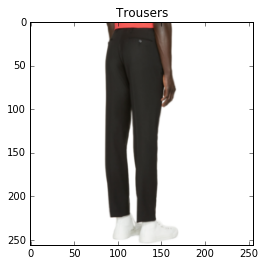

In [82]:
plt.title(id2category[int(metadata[0])])
plt.imshow(img);
print("Raw text: \n%s\n" % ' '.join(text_batch[0][0].split()))
print("Normalized text: \n%s\n" %  ' '.join(normalize(text_batch, tokenize=True)))
print("Normalized text with vocab: \n%s\n" %  ' '.join(normalize(text_batch, vocab, tokenize=True)))
plt.show()

## To be consistent with StackGAN

In [79]:
img_304 = scipy.misc.imresize(img, [BIG_SIZE, BIG_SIZE], 'bicubic')
img_76 = scipy.misc.imresize(img, [SMALL_SIZE, SMALL_SIZE], 'bicubic')

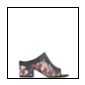

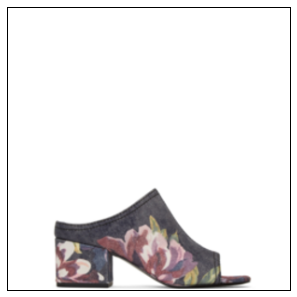

In [80]:
clean_plot_dpi(img_76, SMALL_SIZE) ; clean_plot_dpi(img_304, BIG_SIZE);

# Text preprocessing for fastText

In [ ]:
from random import sample

def clean_line(text):
    return text.translate(None, BLACK_LIST).lower()

def process(line):
    label, text = line.split(" ", 1)
    return "%s %s\n" % (label, clean_line(line))

def strip(line):
    _, text = line.split(" ", 1)
    return "%s\n" % clean_line(text)

with open(FASTTEXT_DATA, 'rt') as f:
    all_lines = f.readlines()
    lines = list(set(all_lines))

with open(FASTTEXT_DATA_TRAIN, 'wt') as f:
    f.writelines(sample([process(line) for line in lines], len(lines)))
    
with open(FASTTEXT_DATA_CLEAN, 'wt') as f:
    f.writelines([strip(line) for line in all_lines])

In [ ]:
from tensorflow.python.client import device_lib

In [ ]:
print(device_lib.list_local_devices())